# 분류
- 이번 장에서는 분류 시스템을 집중적으로 다루겠다.

## 설정

In [51]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os


# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

이번 장에서는 고등학생과 미국 인구조사국 직원들이 손으로 직접 쓴 70000개의 작은 숫자 이미지, MNIST 데이터셋을 사용하겠다.
각 이미지에는 어떤 숫자를 나타내는지 레이블이 달려있다.
너무도 많이 사용되기 때문에 머신러닝 분야의 Hello World라고 불린다.
다음은 MNIST 셋을 다운로드 받는 코드이다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #⚠️ 특정 버전 이상부터는 as_frame에 false넣어야 pandas.dataFrame이 아닌 np.array로 리턴됨!
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

위에처럼 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖고 있다.
여러가지 키가 있지만 그중 대표적인 키는 DESCR(데이터셋을 설명하는 DESCR 키), data(샘플이 하나의 행, 특성이 하나의 열로 구성된 말 그대로 데이터가 담긴 배열), target(레이블 배열을 담고 있다.)가 있다.
이 배열들을 살펴보자!

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

데이터 키와 대응되는 value에는 이미지가 70,000개 있고 각 이미지에는 784개의 feature가 있다. 
이미지가 28*28 픽셀이기 떄문이다. 각 픽셀에 해당하는 intensity를 전부 갖고 있는 것이다.
데이터셋에서 이미지 하나를 뽑아서 확인해보자.
샘플의 특성 벡터를 추출해서 28*28 배열로 크기를 바꾸고 matplotlib의 imshow() 함수를 사용해 그리면 된다.

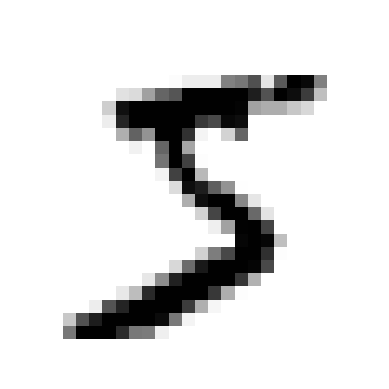

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

레이블은 문자열로 되어있기 때문에 이를 정수로 변경해준다.

In [6]:
y = y.astype(np.uint8)

앞장에서 배웠듯이 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야한다. 
사실 MNIST 데이터셋은 이미 훈련 세트(이미지 60000개)와 테스트 세트(뒤쪽 10000개)로 나누어놓았다.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷한 비율로 맞춘다.

# 이진 분류기 훈련

문제를 단순화해서 하나의 숫자만 식별해보자. 예를 들어 5라고 한다면, 5와 5아님 이 두 개의 클래스를 구분할 수 있는 것이
바로 이진 분류기라고 한다.
먼저 분류 작업을 위한 타깃 벡터를 만들어보자.

In [8]:
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

이제 분류 모델을 하나 선택해서 훈련시켜보자.
SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기로 시작하는 것이 좋을 것 같다.
이 SGDClassifier는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 갖고 있다. 
(SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다.)
SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜보자.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

이제 이 모델을 사용해 숫자 5의 이미지를 감지해보겠다.

In [10]:
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([False])

이제 모델의 성능을 확인해보자!

## 성능 측정

분류기 평가는 회귀 모델보다 훨씬 어렵다.

### 교차 검증을 사용한 정확도 측정
- 2장에서 했던 것처럼 교차 검증은 모델을 평가하는 좋은 방법이다.
- StratiefiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다.

cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해보겠다.
k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억하고 있는지 모르겠다(2장 교차검증 파트에서 배웠다!)

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상이다!!
이제 모든 이미지를 5아님 클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이번에도 정확도가 90% 이상으로 나왔다!
사실 이미지의 10% 정도만 숫자 5이기 때문에 무조건 5아님으로 예측하면 정확히 맞출 확률이 90%이다.
이처럼 지금의 예시는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

## 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)을 조사하는 것이다.
기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.
예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.
오차 행렬을 만들기 위해서는 실제 target과 비교할 수 있도록 먼저 예측값을 만들어야 한다.
(테스트 세트로 예측을 만들수는 있지만 그건 여기서 사용할 것이 아니다! 출시 준비를 마치고 맨 마지막에 사용하는 것을 잊지 말자)
대신 cross_val_predict() 함수를 사용할 수 있다.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고
각 테스트 폴드에서 얻은 예측을 반환한다.
즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다. (깨끗 = 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측)
이제 confusion_matrix() 함수를 이용해 오차 행렬을 만들 준비가 되었다.
타깃 클래스인 y_train_5와 예측 클래스인 y_train_pred를 넣고 호출하면 된다.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.
여기서 첫번째 행은 5아님 이미지에 대한 것으로 53892개를 5아님으로 정확하게 분류했고 (true negative)
나머지 687개는 5라고 잘못 분류했다. (false positive)
2번째 행은 5로 분류한 이미지에 대한 것으로 1891개를 5아님으로 잘못 분류했고 (false negative)
3530개를 5라고 제대로 분류했다. (true positive)

만약 완벽한 분류기라면 진짜 양성과 진짜 음성만 갖고 있을테니 오차 행렬의 주대각선만 0이 아닌 값이 된다!

오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요할 때도 있다.
하나의 예로 양성 예측의 정확도가 있다.
이런 양성 예측의 정확도를 분류기의 정밀도(precision)라고 한다.

<b>precision = True_Positive / Positive </b>

확실한 Positive 샘플 하나만 예측하면 간단히 완벽한 정밀도를 얻을 수 있지만 다른 모든 양성 샘플을 무시하기 때문에 유용하지 않아보인다. 

이 정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 

<b> recall = true_positive / (true_positive + false_negative)</b>

민감도(sensitivity) 또는 진짜 양성 비율(true positive rate)라고도 한다.

## 정밀도와 재현율
사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 정밀도 : y_train_5가 5인지 아닌지의 라벨임을 잊지 말자!

np.float64(0.8370879772350012)

In [17]:
recall_score(y_train_5, y_train_pred) #재현율 4096 / (4096 + 1325)

np.float64(0.6511713705958311)

정확도에서 봤을 때만큼 좋게 나오지는 않았다.
약 83.7%만 정확하다. 더군다나 전체 숫자 5에서 65.1%만 감지했다.
정밀도와 재현율을 F1 점수 (F1 score)라고 하는 하나의 숫자로 만들면 편리할 때가 많다.
특히 두 분류기를 비교할 때 그렇다.
F1 점수는 정밀도와 재현율의 조화 평균(harmonic mean)이다.

<b> 2x(정밀도 x 재현율) / (정밀도 + 재현율)</b>

역시나 따로 함수가 존재해서
f1_score() 함수를 호출하면 된다.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 하지만 이게 항상 좋은 것 만은 아니다!
상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있다.
예를 들어 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정하자.
재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 (낮은 재현율) 
안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것이다.

다른 예시로 감시 카메라를 통해 좀도둑을 잡아내는 분류기가 있다고 해보자.
분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지도 모른다.

아쉽지만 이 둘을 모두 얻을 수는 없다. 
정밀도를 올리면 재현율이 줄고, 재현율을 높히면 정밀도가 줄기 때문이다.
즉 이 둘은 트레이드 오프 관계에 있다.

## 정밀도/재현율 트레이드오프
SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 트레이드 오프 관계를 알아보자.
이 분류기는 decision function(결정 함수)를 사용하여 각 샘플의 점수를 계산한다.
이 점수가 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 negative로 할당한다.

만약 결정 임계값을 중심으로 양 쪽에 5를 나타낸 이미지들이 나열되어있다고 하자.
그 중 오른쪽 즉 양성이라고 판단한 쪽에는 진짜 5 4개 (true positive) 가까 5 1개가 있다(false positive)
실제로는 [8 7 3 9 5 2 5 | 5 6 5 5 5] 이렇게 배치되어있다.
여기서 만약 결정 임계값을 오른쪽으로 두칸 정도 옮기면 
false positive 였던 6이 진짜 음성으로 판단되어(5아님) 정밀도가 높아진다.
대신 기존에 진짜 양성이었던 5하나가 음성으로 판단되므로 재현율이 줄어든다.

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
여기서 우리가 수동으로 나만의 임계값을 기준으로 예측을 만들어낼 수는 있다.

In [19]:
y_scores = sgd_clf.decision_function([some_digit]) # X[0] 진짜 5임
y_scores

array([-3491.23647576])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

우리가 설정한 SGDClassifier의 임계값이 0이므로 위 코드는 predict() 메서드와 같은 결과인 True를 반환한다.
임계값을 높여보자.

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이미지가 실제로 숫자 5이고 임계값이 0일 때는 분류기가 이를 감지했지만, 임계값을 8000으로 높이면 이를 놓치게 된다.
그렇다면 적절한 임계값을 어떻게 정할 수 있을까?
이를 위해선 먼저 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
당연히 위에서 사용했던 방식과 똑같지는 않고 예측 결과가 아닌 <b>결정 점수</b>를 반환받도록 지정해야 한다.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

이 결정 점수로 precision_recall_curve() 함수를 사용해서 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있다.

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

이제 matplotlib를 통해 임계값의 함수로 정밀도와 재현율을 그릴 수 있다.

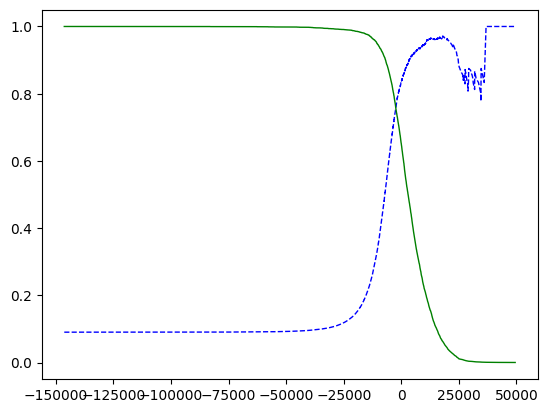

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=1)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#임계값을 올리더라도 가끔 정밀도가 낮아지는 경우가 있어(위에서 본 예시처럼) 정밀도가 울퉁불퉁하게 나온다.
#반면 재현율은 임계값이 올라감에 따라 줄어들 수밖에 없어 부드러운 곡선이 된다.

좋은 정밀도/재현율 트레이드 오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

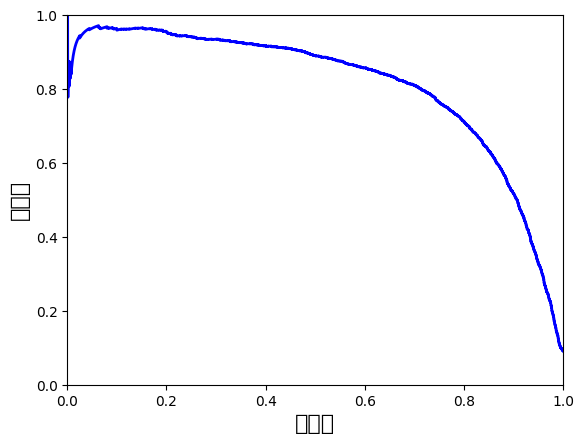

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)
plt.show()

재현율 80% 이전부터 정밀도가 급격하게 줄어들기 시작한다.
이 하강점 직전을 정밀도/재현율 트레이드 오프로 선택하는 것이 좋다.
만약 여기서 정밀도 90%를 달성하는 것이 목표라고 가정하자. 그럼 임계값은 약 6000정도라는 것을 알 수 있다.
np.argmax (최댓값의 첫 번째 인덱스를 반환)를 통해 최소 90% 정밀도가 되는 가장 낮은 임계값을 찾을 수 있다.

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #즉 가장 낮은 임계값을 찾는다!

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision) # 훈련 세트에 대한 예측을 만든다.

precision_score(y_train_5, y_train_pred_90) # 예측 정밀도 확인

np.float64(0.9000345901072293)

In [35]:
recall_score(y_train_5, y_train_pred_90) # 예측 재현율 확인

np.float64(0.4799852425751706)

위와 같이 정밀도 90%를 달성한 분류기를 만들었다. 하지만 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않게 된다.

## ROC 곡선 : 이진 분류에 사용
ROC curve는 이진 분류에서 널리 사용하는 도구이다.
정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고
False Positive Rate에 대한 True Positive Rate(재현율)의 곡선이다.
* FPR = 1 - TNR이다.
양성으로 잘못 분류된 음성 샘플의 비율이 FPR이다.
<b> FPR = FP / (FP+TN) </b>
TNR은 특이도(specificity)라고 불리기도 하며 음성으로 정확하게 분류한 음성 샘플의 비율이다.
이를 정리하면 ROC curve는 민감도(재현율)에 대한 1-특이도 그래프이다.

ROC curve를 그리려면 먼저 roc_curve() 함수를 사용해 여러 임계값에서 TPR과 FPR을 계산해야 한다.

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

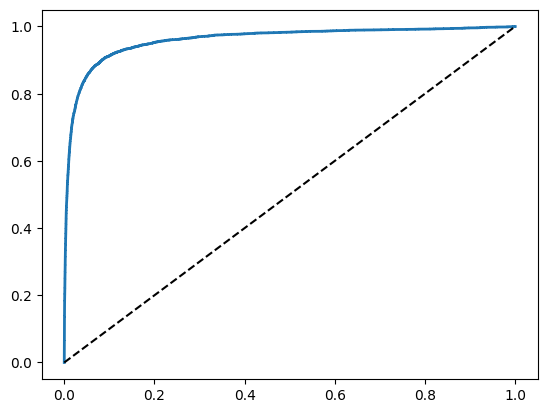

In [39]:
#matplotlib를 통해 TRP에 대한 FPR의 곡선 나타내기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선 추가


plot_roc_curve(fpr, tpr)
plt.show()

여기에도 엄연히 트레이드 오프가 있다. <br>
TPR(재현율)이 높을수록 분류기가 만드는 FPR이 늘어난다. 
점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다 : 이 이상 내려가지 x 
AUC(곡선 아래의 면적)을 측정하면 분류기들을 비교할 수 있다. 
완벽한 분류기는 ROC의 AUC가 1이다.
사이킷런은 ROC의 AUC를 계산하는 함수를 제공한다.

In [40]:
from sklearn.metrics import roc_auc_score

In [41]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

그렇다면 ROC 곡선과 정밀도/재현율 곡선 중 어떤 것을 사용해야 할지 궁금할 수 있다.
Positive 클래스가 드물거나 False Negative 보다 False Positive이 더 중요할 때 PR 곡선을 사용하고
반대로 False Positive보다 False Negative가 더 중요하면 ROC 곡선을 사용한다.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 AUC 점수를 비교해보자.
먼저 훈련 세트의 샘플에 대한 점수를 얻어야 한다.
하지만 앞에서와 달리 RandomForestClassifier에는 decision_function() 메서드가 없다.
대신 predict_proba() 메서드가 존재한다.
사이킷런 분류기는 일반적으로 이 두 메서드(decision_function()과 predict_proba()) 중 하나 또는 둘 모두를 갖고 있다.
predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

In [54]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

roc_curve()는 레이블과 점수를 기대한다.
하지만 점수 대신에 클래스 확률을 전달할 수도 있다!

In [55]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용한다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

이제 ROC 곡선을 그릴 준비가 되었다. 비교를 위해 첫번째 ROC 곡선도 함께 나타냈다.

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

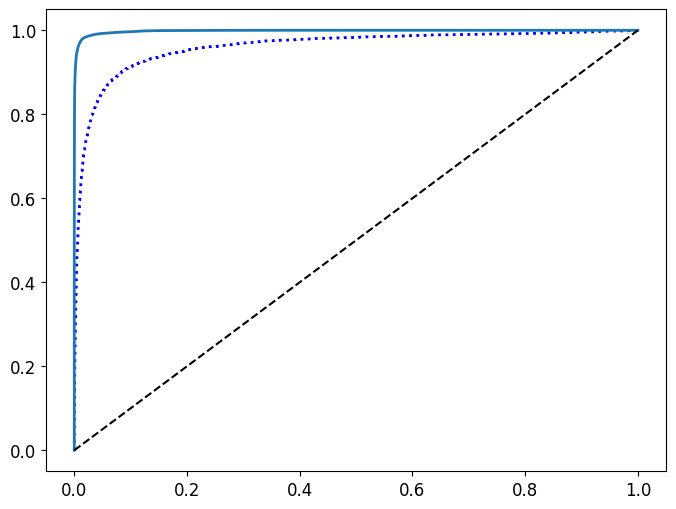

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.show()

RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 더 좋아 보인다.

이제 다음으로는 숫자 5 이상을 감지해보겠다.

# 다중 분류
이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기는 둘 이상의 클래스를 구별할 수 있다.<br>
SGD classifier, RandomForest Classifier, naive Bayes Classifier와 같은 일부 알고리즘은 여러 개의 클래스를
직접 처리할 수 있는 반면, 로지스틱 회귀나 support vector machine같은 다른 알고리즘은 이진 분류만 가능하다.<br>
하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많이 존재한다.<br>
단순하게 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다.<br>
이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다.<br>
이를 OvR(one-versus-the-rest 전략)이라고 한다.<br>

또 다른 전략은 각 숫자의 조합마다 이진 분류기를 훈련시키는 것이다. 이를 OvO(one-versus-one)전략이라고 한다.<br>
클래스가 N개라면 분류기는 Nx(N-1)/2개가 필요하다.<br>
MNIST 문제에서는 45개의 분류기를 훈련시켜야 한다.
<br>

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.
간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 된다.
예를 들어 다음 코드는 SVC 기반으로 OvR 전략을 사용하는 다중 분류기를 만든다.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

SGDClassifier를 훈련시키는 것도 간단하다.

In [61]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요가 없다.<br>
decision_function() 메서드는 클래스마다 하나의 값을 반환한다.<br>
SGD 분류기가 클래스마다 부여한 점수를 확인해보겠다.

In [62]:
sgd_clf.decision_function([some_digit])

array([[-42309.24702339, -24514.78707295, -21802.99686514,
          -253.56670849,  -6692.29918582,  -5022.40064344,
        -34623.10033652,  -8392.84727568,  -3181.89959952,
         -2356.71582334]])

이녀석...자신감이 엄청나다!<br>
해당 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있다. 
대부분의 점수가 큰 음수이기 때문이다.
이제 물론 앞에서 했던 바와 같이 분류기를 평가해보고 싶을 것이다.
분류기 평가에는 일반적으로 교차 검증을 사용한다. (앞에서 맨 처음 했던 것과 같이...)
cross_val_score() 함수를 사용해 SGDClassifier의 정확도를 평가해보겠다.

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [64]:
# 간단하게 입력의 스케일을 조정해서 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석
실제 프로젝트라면 데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 모델 몇 개를 골라<br>
GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝하고 앞 장에서 한 것처럼 가능한 한 자동화한다.<br>
이 절에서는 이미 가능성이 높은 한 모델을 찾았다고 가정하고, 이 모델의 성능을 향상시킬 방법을 찾아보겠다.<br>

<br>
한 가지 방법은 만들어진 에러의 종류를 분석하는 것이다.<br>
먼저 오차 행렬을 살펴볼 수 있다. 아까 위에서 배웠듯이 cross_val_predict() 함수를 사용해 예측을 만들고 <br>
이전처럼 confusion_matrix() 함수를 호출한다.

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

많은 숫자가 출력된다. 오차 행렬을 matplotlib의 matshow() 함수를 사용해 이미지로 표현하면 보기에 편할 때까 많다.

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

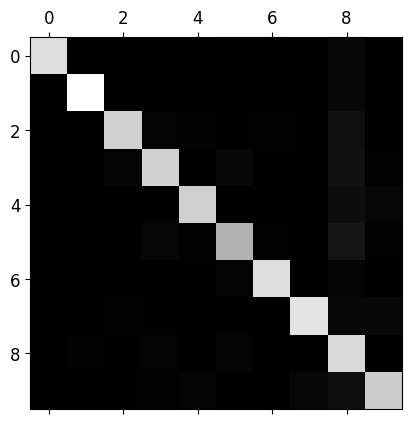

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차 행렬은 대부분의 이미지가 주대각선에 있으므로 매우 좋아보인다.
그 중 숫자 5는 다른 숫자보다 조금 더 어두워 보인다.
이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 이야기이다.
이 두 경우 모두를 확인해봐야 한다.

<br>
그래프의 에러 부분에 초점을 맞춰 살펴보자.
먼저 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다. (이러면 이미지가 많으 클래스가 상대적으로 나쁘게 보인다.)

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

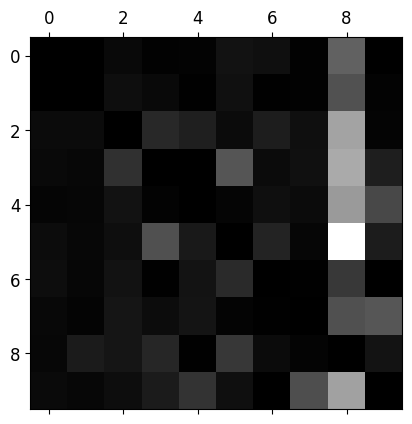

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있다.
다시 말하지만 오차 행렬에서 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다!
클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류됨을 알 수 있다.
하지만 클래스 8의 행은 그리 나쁘지 않다.
이는 실제 8 자체는 적절히 8로 분류되었음을 나타낸다.
여기서 볼 수 있듯이 오차 행렬은 반드시 대칭인 것은 아니다.

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.
이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.
예를 들어 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다.

# 다중 레이블 분류
지금까지는 각 샘플이 하나의 클래스에만 할당되었다.
하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.
얼굴 인식 분류기를 한 번 생각해보자.
같은 사진에 여러 사람이 등장한다면 인식된 사람마다 하나씩 꼬리표(tag)를 붙여야 한다.
분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되엇다고 가정하자.
분류기가 만약 앨리스와 찰리가 있는 사진을 본다면 [1, 0, 1]을 출력해야 할 것이다.
이처럼 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다!
여기서는 더 간단한 예를 살펴보겠다.

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7,8,9 인지
y_train_odd = (y_train % 2 == 1) # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd] #다중타깃배열 : 첫번째 열 7,8,9인지 두 번째 열 홀수인지

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다.
첫 번째 열은 숫자가 7,8,9인지 나타내고, 두 번째는 홀수인지 나타낸다.
그 다음 줄이 KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용해서 훈련시킨다.
(여기서 KNeighborClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다!)
이제 예측을 만들면 레이블이 두 개 출력된다.

In [72]:
knn_clf.predict([some_digit]) #...? 왜 이렇게 나오는지 모르겠다. [False, True]가 정상인데

array([[ True,  True]])

다중 레이블 분류기를 평가하는 방법은 많다. 적절한 지표는 프로젝트에 따라 다르다. 
예를 들어 각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산한다.
다음 코드는 모든 레이블에 대한 F1 점수의 평균을 계산한다.

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

# 다중 출력 분류
마지막으로 알아볼 분류 작업은 다중 출력 다중 클래스 분류이다.<br>
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.<br>
이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보겠다.<br>
잡음이 많은 숫자 이미지를 입력으로 받고, 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 intensity를 담은 배열로 출력한다. <br>
분류기의 출력이 다중 레이블이고 (픽셀당 한 레이블) 각 레이블은 값을 여러개 갖는다(0~255 - 이걸 회귀가 아니라 분류로 본 것!)

<br>
먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음을 추가하겠다.
타깃 이미지는 원본 이미지가 될 것이다.

In [76]:
noise = np.random.randint(0, 100, (len(X_train), 784)) #모든 픽셀 intensity에 노이즈 배열 만들어
X_train_mod = X_train + noise #여기서 노이즈 부여
noise = np.random.randint(0, 100, (len(X_test), 784)) #이건 test를 위한 노이즈
X_test_mod = X_test + noise #노이즈 부여
y_train_mod = X_train
y_test_mod = X_test

이제 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보겠다.

In [85]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

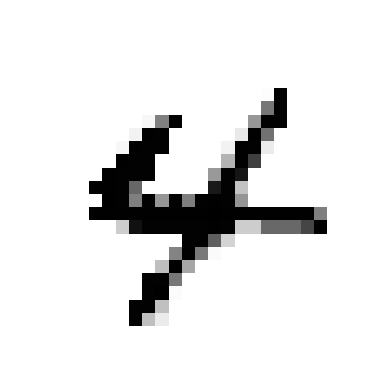

In [87]:
some_index = 5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)